# Simulatie random variables

In [161]:
import time
import matplotlib.pyplot as plt
import numba
import numpy as np
from numba import njit
from numpy import random

# Simulate exponential rv
@njit
def sim_exp(mu):
    u = random.uniform(0.0, 1.0)
    B = -np.log(u) * (1 / mu)
    return B

# Simulate hyper exponential
@njit
def sim_hyp_exp(vMu, vPhaseProb):
    fU = random.uniform(0.0, 1.0)
    vProbBounds = np.cumsum(vPhaseProb)
    B = sim_exp(vMu[np.argmin((fU >= vProbBounds))])
    return B

# Simulate Poisson rv
@njit
def sim_poisson(w):
    u_0 = random.uniform(0.0,1.0)
    n = 0
    while u_0 >= np.exp(-w):
        u_new = random.uniform()
        u_0 = u_0 * u_new
        n += 1
    return n

# Simulate Hyper Erlang
@njit
def sim_hyp_Erlang(fMu, iNPhases, fPhaseProb):
    """
    fMu = Rate of exponentials
    iNPhases = Number of exponentials
    fPhaseProb = p-value s.t. Erlang(k-1), p-1 s.t Erlang(k)
    """
    fU = random.uniform(0.0, 1.0)
    if fU < fPhaseProb:
        vExponentials = np.array([sim_exp(fMu) for i in range(iNPhases-1)])
        fErlang = np.sum(vExponentials)
    else:
        vExponentials = np.array([sim_exp(fMu) for i in range(iNPhases)])
        fErlang = np.sum(vExponentials)
    return fErlang

# Simulate Log-Nornal
@njit
def sim_lognormal(fMu,fSigma2):
    Z = np.sqrt(-2*np.log(random.uniform(0.0, 1.0)))*np.cos(2*np.pi*random.uniform(0.0, 1.0))
    return np.exp(fMu + np.sqrt(fSigma2)*Z)

# Find parameters for hyper Exponential 2 distribution with variance var_x and expectation 1
@njit
def search_par_hypexp_2(var_x):
    p_1 = 0.5*(1 + np.sqrt((var_x - 1)/(var_x +1)))
    p_2 = 1 - p_1
    mu_1 = 2*p_1
    mu_2 = 2*p_2
    return [np.array([mu_1,mu_2]),np.array([p_1,p_2])]

# Find parameters for hyper Erlang distribution with variance var_x and expectation 1
@njit
def search_par_hypErlang(fCx2):
    iK = np.ceil(1/fCx2)
    fP = 1 /(1 + fCx2) * (iK*fCx2 - (iK*(1 + fCx2) - (iK**2)*fCx2)**(1/2))
    fMu = iK - fP
    return [fMu, iK, fP]

#Find Parameters log-normal
@njit
def search_par_lognormal(fCx2):
    fSigma2 = np.log(fCx2 + 1)
    fMu = -0.5*fSigma2
    return [fMu,fSigma2]

@njit
def get_Uarray(iU,nUvals=10):
    #iNumberValU = int(np.floor((iU - 1)/2))
    vUarray = np.linspace(1,iU,nUvals)
    return vUarray

In [179]:
# Simulate p(u) for HyperErlang 
from numba import jit
@njit
def simulate_hypErlang_q(vModel, fOmega, iNPhases, fPhaseProb):
    iNruns = 100
    iU = vModel[0]
    fR = vModel[1]
    iLambdaP = vModel[2]
    fMu = vModel[3]
    iNumberValU = 10

    fThetaStar = fMu - (iLambdaP / fR)
    fLambdaQ = iLambdaP * fMu / (fMu - fThetaStar)
    fMuQ = fMu - fThetaStar

    mYt = np.zeros((iNumberValU, iNruns), dtype= numba.float64)
    # mYt = np.zeros((iNumberValU, iNruns))
    for i in range(iNruns):
        fYt = 0.0
        iCounterU = -1
        vUarray = np.linspace(1,iU,iNumberValU)
        while fYt < vUarray[-1]:
            # Get length interinspection time
            fOmega_i = sim_hyp_Erlang(fOmega, iNPhases, fPhaseProb)
            
            # Get number of claims in timestep omega_i
            fMeanPoissonQ = fLambdaQ * fOmega_i
            iN_i = random.poisson(fMeanPoissonQ)
            #N_i = sim_poisson(lambda_q*omega_i)

            # Get all claims counted up made over timestep omega_i
            fClaims = 0.0
            for j in range(iN_i):
                B_ij = random.exponential(1/fMuQ)
                fClaims = fClaims + B_ij
            
            # Calculate Y on t + omega_i
            fYt = fYt + fClaims - (fR * fOmega_i)
            
            # Check if u_i is surpassed
            if fYt >= vUarray[0] and len(vUarray) > 1:
                iCounterU += 1
                mYt[iCounterU, i] = np.exp(-fThetaStar * fYt)
                vUarray = np.delete(vUarray, 0)
        
        # Add the yT at ruin for biggest u Value
        iCounterU += 1
        mYt[iCounterU,i] = np.exp(-fThetaStar * fYt)

    # Calculate the mean of all the probabilities per row (u value)
    vPu = np.zeros(iNumberValU, dtype= numba.float64)
    for iRowIndex, vRow in enumerate(mYt):
        fRowMean = np.mean(vRow)
        vPu[iRowIndex] = fRowMean
    return vPu

In [181]:
# Simulate p(u) for HyperExp 
@njit
def simulate_hypExp_q(vModel, vRates, vPhaseProb):
    iNruns = 100
    iU = vModel[0]
    fR = vModel[1]
    iLambdaP = vModel[2]
    fMu = vModel[3]
    iNumberValU = 10

    fThetaStar = fMu - (iLambdaP / fR)
    fLambdaQ = iLambdaP * fMu / (fMu - fThetaStar)
    fMuQ = fMu - fThetaStar

    mYt = np.zeros((iNumberValU, iNruns), dtype= numba.float64)
    for i in range(iNruns):
        fYt = 0.0
        iCounterU = -1
        vUarray = np.linspace(1,iU,iNumberValU)
        while fYt < vUarray[-1]:
            # Get length interinspection time
            fOmega_i = sim_hyp_exp(vRates, vPhaseProb)
            
            # Get number of claims in timestep omega_i
            fMeanPoissonQ = fLambdaQ * fOmega_i
            iN_i = random.poisson(fMeanPoissonQ)
            #N_i = sim_poisson(lambda_q*omega_i)

            # Get all claims counted up made over timestep omega_i
            fClaims = 0.0
            for j in range(iN_i):
                B_ij = random.exponential(1/fMuQ)
                fClaims = fClaims + B_ij
            
            # Calculate Y on t + omega_i
            fYt = fYt + fClaims - (fR * fOmega_i)
            
            # Check if u_i is surpassed
            if fYt >= vUarray[0] and len(vUarray) > 1:
                iCounterU += 1
                mYt[iCounterU, i] = np.exp(-fThetaStar * fYt)
                vUarray = np.delete(vUarray, 0)
        
        # Add the yT at ruin for biggest u Value
        iCounterU += 1
        mYt[iCounterU,i] = np.exp(-fThetaStar * fYt)
        
    # Calculate the mean of all the probabilities per row (u value)
    vPu = np.zeros(iNumberValU, dtype= numba.float64)
    for iRowIndex, vRow in enumerate(mYt):
        fRowMean = np.mean(vRow)
        vPu[iRowIndex] = fRowMean
    return vPu

In [182]:
# Simulate p(u) for LogNormal 
@njit
def simulate_lognormal_q(vModel, fMuV, fSigma2):
    iNruns = 100
    iU = vModel[0]
    fR = vModel[1]
    iLambdaP = vModel[2]
    fMu = vModel[3]
    iNumberValU = 10

    fThetaStar = fMu - (iLambdaP / fR)
    fLambdaQ = iLambdaP * fMu / (fMu - fThetaStar)
    fMuQ = fMu - fThetaStar

    mYt = np.zeros((iNumberValU, iNruns), dtype= numba.float64)
    for i in range(iNruns):
        fYt = 0.0
        iCounterU = -1
        vTauYt = np.zeros(iNumberValU, dtype= numba.float64)
        vUarray = np.linspace(1,iU,iNumberValU)
        while fYt < vUarray[-1]:
            # Get length interinspection time
            fOmega_i = sim_lognormal(fMuV, fSigma2)
            
            # Get number of claims in timestep omega_i
            fMeanPoissonQ = fLambdaQ * fOmega_i
            iN_i = random.poisson(fMeanPoissonQ)
            #N_i = sim_poisson(lambda_q*omega_i)

            # Get all claims counted up made over timestep omega_i
            fClaims = 0.0
            for j in range(iN_i):
                B_ij = random.exponential(1/fMuQ)
                fClaims = fClaims + B_ij
            
            # Calculate Y on t + omega_i
            fYt = fYt + fClaims - (fR * fOmega_i)
            
            # Check if u_i is surpassed
            if fYt >= vUarray[0] and len(vUarray) > 1:
                iCounterU += 1
                mYt[iCounterU, i] = np.exp(-fThetaStar * fYt)
                #vTauYt[iCounterTauYt] = np.exp(-fThetaStar * fYt)
                vUarray = np.delete(vUarray, 0)
        
        # Add the yT at ruin for biggest u Value
        iCounterU += 1
        mYt[iCounterU,i] = np.exp(-fThetaStar * fYt)

    # Calculate the mean of all the probabilities per row (u value)
    vPu = np.zeros(iNumberValU, dtype= numba.float64)
    for iRowIndex, vRow in enumerate(mYt):
        fRowMean = np.mean(vRow)
        vPu[iRowIndex] = fRowMean
    # vPu = np.mean(mYt, axis=1)
    return vPu

In [167]:
# Gives for every value of u an array of p(u) values per variance 
# Gives back a matrix with all ruin probabilities where every row corresponds 
# to a value u and every column corresponds to a variance
@njit
def get_results_hypErlang(iNumberVar = 50, iU = 60):
    vModelVal = np.array([iU,1.2,2,2])
    vUarray = get_Uarray(iU)
    vVar = np.linspace(0.001,0.999,iNumberVar)
    mU_Var_hypErlang = np.zeros((len(vUarray), iNumberVar), dtype= numba.float64)
    for iIndex, fV in enumerate(vVar):
        parameters = search_par_hypErlang(fV)
        vPu_hypErlang = simulate_hypErlang_q(vModelVal,parameters[0],int(parameters[1]),parameters[2])
        mU_Var_hypErlang[:,iIndex] = vPu_hypErlang
    return mU_Var_hypErlang

@njit
def get_results_hypExp(iNumberVar = 100, iU = 60):
    vModelVal = np.array([iU,1.2,2,2])
    vUarray = get_Uarray(iU)
    vVar = np.linspace(1,3,iNumberVar)
    vVar_Pu_hypExp = np.zeros((len(vUarray), iNumberVar), dtype= numba.float64)
    for iIndex, fV in enumerate(vVar):
        parameters = search_par_hypexp_2(fV)
        vPu_hypExp = simulate_hypExp_q(vModelVal,parameters[0],parameters[1])
        vVar_Pu_hypExp[:,iIndex] = vPu_hypExp
    return vVar_Pu_hypExp

@njit
def get_results_lognormal(iNumberVar = 150, iU = 60):
    vModelVal = np.array([iU,1.2,2,2])
    vUarray = get_Uarray(iU)
    vVar = np.linspace(0.01,3,iNumberVar)
    vVar_Pu_lognormal = np.zeros((len(vUarray), iNumberVar), dtype= numba.float64)
    for iIndex, fV in enumerate(vVar):
        parameters = search_par_lognormal(fV)
        vPu_lognormal = simulate_lognormal_q(vModelVal,parameters[0],parameters[1])
        vVar_Pu_lognormal[:,iIndex] = vPu_lognormal
    return vVar_Pu_lognormal

In [168]:
# Get smooth results for HypErlang, Hypexp, Lognormal
def get_smooth_results_hypErlang(iU = 60,iX = 50):
    vUarray = get_Uarray(iU)
    #iX = 50 #Number of variances
    iY = len(vUarray) #Number of u values
    iZ = 1000 #Number of runs for smoothing

    Matrix3D = np.zeros((iZ,iY,iX))
    for i in range(iZ):
        mResult = get_results_hypErlang(iNumberVar=iX, iU=iU)
        Matrix3D[i,:,:] = mResult
    mSmoothResult = np.mean(Matrix3D, axis=0)
    return mSmoothResult

def get_smooth_results_hypExp(iU = 60,iX = 100):
    vUarray = get_Uarray(iU)
    #iX = 100 #Number of variances
    iY = len(vUarray) #Number of u values
    iZ = 1000 #Number of runs for smoothing

    Matrix3D = np.zeros((iZ,iY,iX))
    for i in range(iZ):
        mResult = get_results_hypExp(iNumberVar=iX, iU=iU)
        Matrix3D[i,:,:] = mResult
    mSmoothResult = np.mean(Matrix3D, axis=0)
    return mSmoothResult

def get_smooth_results_lognormal(iU = 60,iX = 150):
    vUarray = get_Uarray(iU)
    #iX = 150 #Number of variances
    iY = len(vUarray) #Number of u values
    iZ = 1000 #Number of runs for smoothing

    Matrix3D = np.zeros((iZ,iY,iX))
    for i in range(iZ):
        mResult = get_results_lognormal(iNumberVar=iX, iU=iU)
        Matrix3D[i,:,:] = mResult
    mSmoothResult = np.mean(Matrix3D, axis=0)
    return mSmoothResult


In [169]:
def cal_gamma(mPlot,iU=60):
    vUarray = get_Uarray(iU)
    fThetaStar = 2 - (2 / 1.2)
    mGammaPlots = []
    for iIndex, vPlot in enumerate(mPlot):
        iUval = vUarray[iIndex]
        vGPlot = vPlot * np.exp(fThetaStar * iUval)
        mGammaPlots.append(vGPlot)
    print(np.shape(mGammaPlots))
    return mGammaPlots

In [170]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size" : 14
})

In [183]:
iU = 64
# Create y values for plot
mPlots_Erlang= get_smooth_results_hypErlang(iU = iU,iX = 50)
mPlots_hypExp = get_smooth_results_hypExp(iU = iU,iX = 100)
vUarray = get_Uarray(iU=iU)
mPlots = np.concatenate([mPlots_Erlang,mPlots_hypExp], axis=1)

# Make array of x values for plot
vVar_1 = np.linspace(0.001,0.999,50)
vVar_2 = np.linspace(1,3,100)
vVar = np.concatenate([vVar_1,vVar_2])


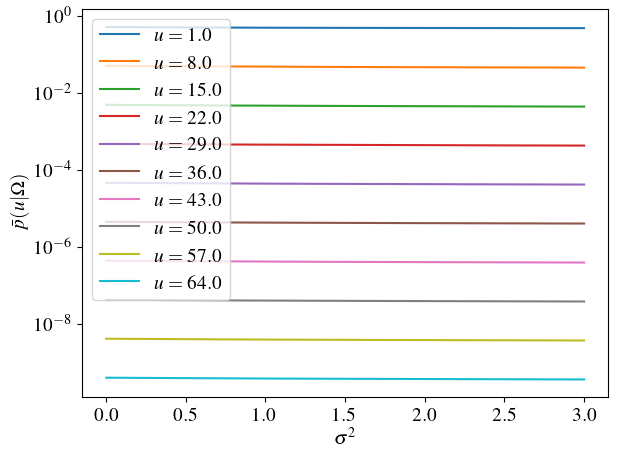

In [184]:
# Make p(u) plot
for iIndex, vPlot in enumerate(mPlots):
    plt.plot(vVar,vPlot, label = f'$u = {vUarray[iIndex]}$')
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$\bar{p}(u|\Omega)$")
plt.yscale("log")
plt.legend(loc="upper left")
plt.tight_layout()

In [186]:
mGplots = cal_gamma(mPlots,iU=64)


(10, 150)


(10, 150)


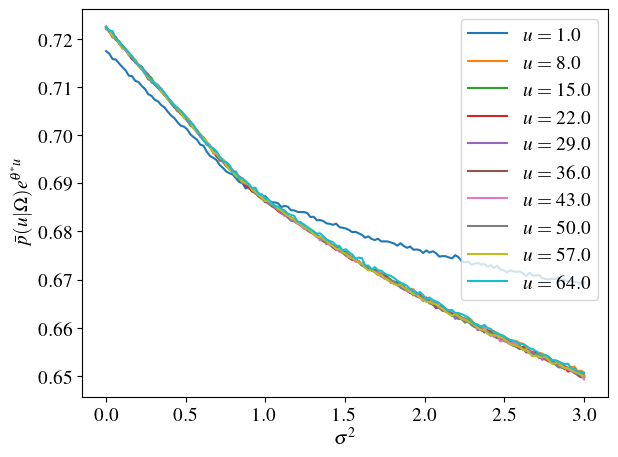

In [187]:
# Make Gamma plot
mGplots = cal_gamma(mPlots,iU=64)
for iIndex, vGPlot in enumerate(mGplots):
    plt.plot(vVar,vGPlot, label = f'$u = {vUarray[iIndex]}$')
    if iIndex==9:
        break
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$\bar{p}(u|\Omega)e^{\theta^* u}$")
plt.legend(loc="upper right")
plt.tight_layout()

In [144]:
test_array = np.array([[1,2], [4,5]])
test_array[:,0] = [9,10]
print(test_array)

[[ 9  2]
 [10  5]]


In [148]:
Matrix3D = np.zeros((3,2,2))
mResult1 = np.array([[1,2], [3,4]])
mResult2 = np.array([[5,6], [7,8]])
mResult3 = np.array([[9,10], [11,12]])
Matrix3D[0,:,:] = mResult1
Matrix3D[1,:,:] = mResult2
Matrix3D[2,:,:] = mResult3
meanmatrix = np.mean(Matrix3D, axis=0)
print(Matrix3D)
print(meanmatrix)


[[[ 1.  2.]
  [ 3.  4.]]

 [[ 5.  6.]
  [ 7.  8.]]

 [[ 9. 10.]
  [11. 12.]]]
[[5. 6.]
 [7. 8.]]
